In [1]:
import torch
device = torch.device("cuda:1") 
dataset_type = "CIFAR10"
model_name = "ResNet20"

import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import my_tools
import fid_score as official_fid

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as all_model

if dataset_type == "CIFAR10":
    if model_name == "ResNet20":
        from CIFAR10.models import ResNet20 as classify_model
        from CIFAR10.models import Rob_predictor as my_Rob_predictor
        from CIFAR10.models import BigGAN


import pickle
import os
import numpy as np
from tqdm import tqdm
from PIL import Image  
from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
import pandas as pd
import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import h5py



In [2]:
class Mydata_sets(Dataset):
    
    def __init__(self, path, transform=None):
        super(Mydata_sets, self).__init__()
        self.root_dir = path
        self.img_names = os.listdir(self.root_dir)
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.root_dir, img_name))
        id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, id_name

    def __len__(self):
        return len(self.img_names)

if dataset_type == "CIFAR10":
    transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Resize((224, 224), interpolation=Image.BICUBIC),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

#### 评估一下分类模型(这里的是特征提取模型)

In [3]:
if dataset_type == "CIFAR10":
    ResNet50 = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet50.pt", map_location=device) # 这个pt文件里不仅仅是参数，包括了模型
    ResNet50 = ResNet50.to(device)
    ResNet50.eval()
    train_dataloader = DataLoader(datasets.CIFAR10('./static/data/CIFAR10/CIFAR10/', train=False, download=True, transform=transform), batch_size=128, shuffle=False)

index = 0
with torch.no_grad():
    train_dataloader = tqdm(train_dataloader)
    total = 0
    correct = 0
    for inputs, labels in train_dataloader:
            inputs,labels = inputs.to(device), labels.to(device)
            # ============= forward =============
            outputs = ResNet50(inputs)
            # ============= precision ===========
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #break
            description = 'correct: %.4f, total: %.4f , accuracy: %.4f' % (correct, total, correct/total)
            train_dataloader.set_description(description)
            train_dataloader.update()
print("最终结果： ", description)

Files already downloaded and verified


correct: 9665.0000, total: 10000.0000 , accuracy: 0.9665: 100%|██████████| 79/79 [01:30<00:00,  1.15s/it]

最终结果：  correct: 9665.0000, total: 10000.0000 , accuracy: 0.9665


#### 获得图片的特征、类别、文件编号

In [4]:
features, labels, ids = [], [], [] # features：提取的2048维图片特征，labels：模型预测的标签，ids图片文件编号

feature_model = copy.deepcopy(ResNet50)
feature_model.fc = nn.Identity() # 相当于取消fc层, 这样
label_model = copy.deepcopy(ResNet50)

# 图片路径
if dataset_type == "CIFAR10":
    pic_path = "./static/data/CIFAR10/pic/random_50k_png"   


img_datasets = Mydata_sets(pic_path, transform=transform)  
# img_datasets = torchvision.datasets.CIFAR10("./static/data/CIFAR10/", train=True, download=False, transform=transform) #使用原始的cifar10图片
imgLoader = torch.utils.data.DataLoader(img_datasets, batch_size=128, shuffle=False, num_workers=4)  # 指定读取配置信息

with torch.no_grad():
    for x, y in tqdm(imgLoader):
        x = x.to(device)
        ids.append(y)  # N
        feature = feature_model(x)  # N, 2048
        features.append(feature)

        ten_D = label_model(x)
        label = torch.argmax(ten_D, dim=1)
        labels.append(label)

features = torch.cat(features, dim=0).squeeze().cpu().numpy()  # (n, 2048)
labels = torch.cat(labels, dim=0).squeeze().cpu().numpy()  # n
ids = torch.cat(ids, dim=0).cpu().numpy() # n

print(features.shape)
print(labels.shape)
print(ids.shape)

100%|██████████| 391/391 [01:47<00:00,  3.64it/s]


(50000, 2048)
(50000,)
(50000,)


#### tsne降维

In [5]:
# 可能比较耗时
embed = TSNE(n_jobs=4).fit(features)  # N, 2

#### 画类别散点图

(50000, 2)
           x          y
0  48.176490 -24.432128
1 -26.687598 -50.952259
2 -52.448406  -9.290452
3 -27.100732  28.422993
4 -51.387352   1.396608
           x          y  label
0  48.176490 -24.432128      8
1 -26.687598 -50.952259      6
2 -52.448406  -9.290452      4
3 -27.100732  28.422993      5
4 -51.387352   1.396608      4
           x          y label
0  48.176490 -24.432128  ship
1 -26.687598 -50.952259  frog
2 -52.448406  -9.290452  deer
3 -27.100732  28.422993   dog
4 -51.387352   1.396608  deer


<AxesSubplot:xlabel='x', ylabel='y'>

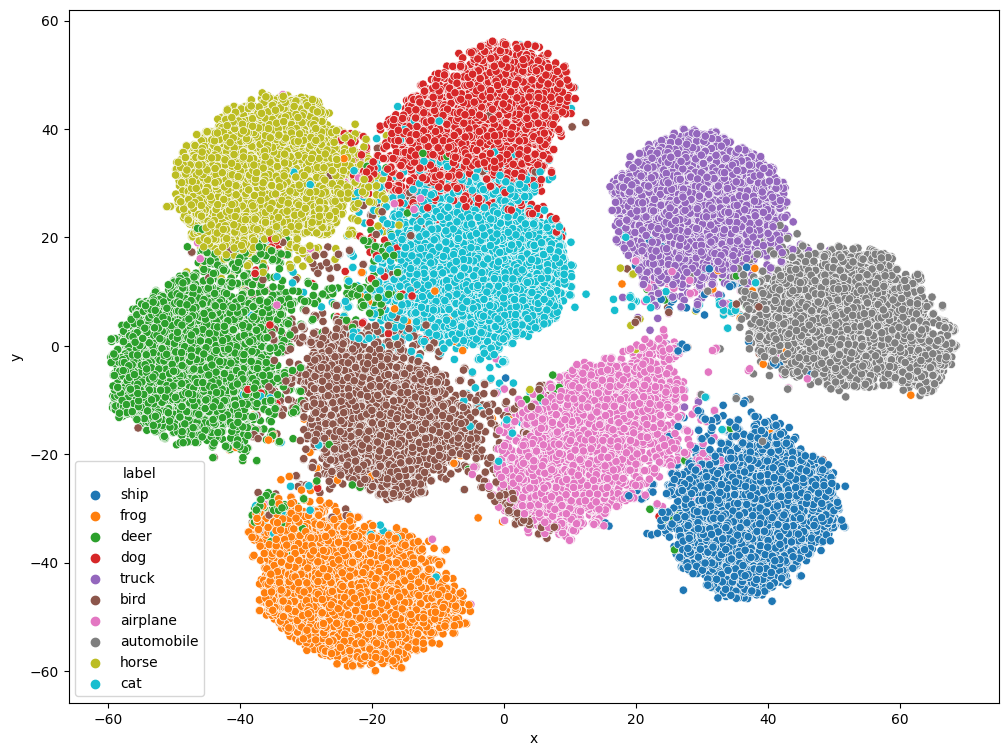

In [6]:
pd_embed = pd.DataFrame(embed)
print(pd_embed.shape)
pd_embed.columns=["x", "y"]
print(pd_embed[:5])
pd_embed.insert(loc=2, column='label', value=labels)
print(pd_embed[:5])
idx_to_class = ["airplane", "automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
pd_embed['label'] = pd_embed['label'].apply(lambda x: idx_to_class[int(x)]) 
print(pd_embed[:5])

sns.set_context({'figure.figsize':[12, 9]})
sns.scatterplot(x="x", y="y", hue="label", data=pd_embed, palette=sns.color_palette("tab10"))

In [7]:
# 插入id
print(pd_embed[:5])
pd_embed.insert(loc=3, column='id', value=ids)
print(pd_embed[:5])

# 把id设置维索引
print(pd_embed[:5])
pd_embed = pd_embed.set_index('id')
pd_embed = pd_embed.sort_index()
print(pd_embed[:5])

# 保留对应的id和坐标
from scipy import spatial
sub_pd = pd_embed.loc[:, ['x', 'y']]
print(sub_pd[:5])
value = sub_pd.values
print(value[:5])
tree = spatial.KDTree(data=value)
if dataset_type == "CIFAR10":
    torch.save(tree, "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png.pt")

           x          y label
0  48.176490 -24.432128  ship
1 -26.687598 -50.952259  frog
2 -52.448406  -9.290452  deer
3 -27.100732  28.422993   dog
4 -51.387352   1.396608  deer
           x          y label     id
0  48.176490 -24.432128  ship  27202
1 -26.687598 -50.952259  frog  43485
2 -52.448406  -9.290452  deer  26658
3 -27.100732  28.422993   dog   7091
4 -51.387352   1.396608  deer  33048
           x          y label     id
0  48.176490 -24.432128  ship  27202
1 -26.687598 -50.952259  frog  43485
2 -52.448406  -9.290452  deer  26658
3 -27.100732  28.422993   dog   7091
4 -51.387352   1.396608  deer  33048
            x          y       label
id                                  
0   56.887060  11.949964  automobile
1   40.486238  19.856550       truck
2    0.298320  36.310673         dog
3  -15.632033 -18.462492        bird
4   40.651535 -25.954662        ship
            x          y
id                      
0   56.887060  11.949964
1   40.486238  19.856550
2    0.298320  36

In [9]:
# 验证一下是否一样
print(pd_embed.iloc[27202])

x         48.17649
y       -24.432128
label         ship
Name: 27202, dtype: object
